In [173]:
from google_play_scraper import app
import pandas as pd
import numpy as np
import sklearn
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import textblob
#from wordcloud import WordCloud
from pathlib import Path
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

import pickle
import re
import time
import datetime                              # access to %%time, for timing individual notebook cells
import os
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (15,10)

In [174]:
#Android App NHS link from Google Play at
#https://play.google.com/store/apps/details?id=uk.nhs.covid19.production&hl=en_GB&gl=US
#The apps ID found in the link after id=uk.nhs.covid19.production
#The apps name on Google Play titled: NHS COVID-19 Department of Health and Social Care, UK Government
#Dated 17 April 2022: number of reviews 134,397

from google_play_scraper import app, Sort, reviews_all

nhs_reviews = reviews_all(
    'uk.nhs.covid19.production',
    sleep_milliseconds=0, # defaults to 0
    lang='en', # defaults to 'en'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
)

In [175]:
#Save the NHS Apps reviews into dataframe
df_nhsrev = pd.DataFrame(np.array(nhs_reviews),columns=['content'])
df_nhsrev = df_nhsrev.join(pd.DataFrame(df_nhsrev.pop('content').tolist()))
df_nhsrev.to_csv(r'C:\Users\Hafidz\PhDwork\APPREV\df_nhsrev.csv', index=False)
df_nhsrev.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOE8qTHGmePIUbbDEY8ejQvC4bb7O3njtMKBiCXD8ku9BGcNLYQopp7zYXcpmBYitJ7LhfxXgkNqd1msnQ,M F,https://play-lh.googleusercontent.com/a/AATXAJyq8p2XVEXdsa3TRti88uANp-N_U2OntrZb3by-=mo,No help at all with my enquiry,1,0,4.28 (303),2022-05-07 18:49:13,None,NaT
1,gp:AOqpTOEo8e8TMWbLb42QrsIUcxHIprCL8sn6ZI926-R6VIJzgPXYmT4Fkzt73BHu1sHX23o-jQHeVDZaUKrpuQ,Trevor Mason,https://play-lh.googleusercontent.com/a/AATXAJzuQXCc-LvS7xUTz33ryixbWzpVva1ZXJd6xcEH=mo,The App is good but trying to get an update for a Travel Pass for my wife is proving difficult. Her 2D runs out on 13th May we go on holiday 18th May I have spent many hours today trying to update...,4,0,4.26.1 (280),2022-05-06 17:34:09,None,NaT
2,gp:AOqpTOEj24wrHYOkqO7nhVX1uD2PGRRpjO6yxZXhdHsafQkJyjp3Dok-I4wvGdJ1USRfEqgt1dEQYfveI8i01Q,Richard Tyson,https://play-lh.googleusercontent.com/a-/AOh14Ggnc-OaO1ONF8D9y1y13RMQ6HBbrfN6kLARGrv5OQ,Didn't work. Pointless. Billions of pounds wasted. Delete this app off the store.,1,1,3.6.1 (70),2022-05-03 11:13:48,None,NaT
3,gp:AOqpTOFtJokjVA_MvkAePjdf1LARVbbH_ryonJjyQ3DtUkJ-hh5F4bXal_4VURfghB8mL0RLFl6ghmYpBRetFw,Ben Shepley,https://play-lh.googleusercontent.com/a-/AOh14Gi71bBYOkVBRNVh4b1JyqFyTui3hbB5jgheUKfI4w,Lols,1,0,None,2022-05-01 18:59:35,None,NaT
4,gp:AOqpTOE-KgqyZSz65hRFqVAeUMLqQuiG6aPfBQmlw6-Z4ShJ1q8VUZIG7fCVKrmO1RqJGOffukK99A5xQjbzGQ,james ball,https://play-lh.googleusercontent.com/a/AATXAJyximAH4ilPZYcwtwntqUeg3RJhmbRmoSh18Nze=mo,Great,5,0,4.27 (297),2022-04-30 16:28:10,None,NaT


In [178]:
#Information on the table 
df_nhsrev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22434 entries, 0 to 22433
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              22434 non-null  object        
 1   userName              22434 non-null  object        
 2   userImage             22434 non-null  object        
 3   content               22434 non-null  object        
 4   score                 22434 non-null  int64         
 5   thumbsUpCount         22434 non-null  int64         
 6   reviewCreatedVersion  19235 non-null  object        
 7   at                    22434 non-null  datetime64[ns]
 8   replyContent          14046 non-null  object        
 9   repliedAt             14046 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(6)
memory usage: 1.7+ MB


In [179]:
print(df_nhsrev.reviewCreatedVersion.unique())
print(df_nhsrev.reviewCreatedVersion.nunique())

['4.28 (303)' '4.26.1 (280)' '3.6.1 (70)' None '4.27 (297)' '4.22 (258)'
 '4.26.2 (286)' '3.7.2 (85)' '4.13.1 (213)' '4.16 (230)' '4.14.1 (225)'
 '4.22.3 (266)' '4.25 (272)' '4.26 (276)' '4.1.1 (124)' '4.17 (240)'
 '4.22.4 (269)' '4.7 (168)' '4.19 (246)' '3.6.2 (73)' '3.10 (100)'
 '4.14 (218)' '4.10 (189)' '4.4 (146)' '4.22.2 (265)' '3.6 (69)'
 '4.22.1 (262)' '4.9 (185)' '3.12.2 (114)' '4.6 (159)' '3.9 (96)'
 '4.19.1 (253)' '4.0.1 (118)' '4.18 (244)' '3.6 (68)' '3.7 (81)'
 '4.1 (123)' '4.12 (201)' '4.5 (152)' '4.2 (131)' '4.3 (136)' '3.1.0 (41)'
 '4.13 (208)' '3.12 (111)' '3.7.1 (83)' '4.8 (178)' '4.7.1 (169)'
 '4.0 (117)' '3.0.0 (35)']
48


In [180]:
#We do not need data for column reviewId, userName, userImage so
#we will show only these column
df_nhsrev.loc[:,["content","score","thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]

,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,No help at all with my enquiry,1,0,4.28 (303),2022-05-07 18:49:13,None,NaT
1,The App is good but trying to get an update for a Travel Pass for my wife is proving difficult. Her 2D runs out on 13th May we go on holiday 18th May I have spent many hours today trying to update...,4,0,4.26.1 (280),2022-05-06 17:34:09,None,NaT
2,Didn't work. Pointless. Billions of pounds wasted. Delete this app off the store.,1,1,3.6.1 (70),2022-05-03 11:13:48,None,NaT
3,Lols,1,0,None,2022-05-01 18:59:35,None,NaT
4,Great,5,0,4.27 (297),2022-04-30 16:28:10,None,NaT
...,...,...,...,...,...,...,...
22429,Tells me is installed but not on phone. Can't get as far as putting the code I have been given in. Doesn't inspire confidence. It eventually downloaded and the code works. This needs to be slicker...,3,7,3.0.0 (35),2020-08-13 16:25:10,"Hello, the app is located next to other apps you have installed on your smartphone, called “NHS COVID-19”. If you are unable to find the app on your device head to our website for further instruct...",2020-08-13 16:13:18
22430,"The emails from the NHS could do a better job of highlighting the access codes, since they do waffle on quite a bit and we're all busy. Assuming you did read your email carefully and collected the...",4,19,3.0.0 (35),2020-08-13 16:04:40,"Hello, thank you for your comments, we really appreciate it. To find out more about the NHS Test and Trace app visit: https://covid19.nhs.uk/",2020-08-14 07:37:04
22431,Seems to work really well. Super simple setup. People stop giving it 1* because you don't have a signup code. That is not what the rating system is for.,5,9,3.0.0 (35),2020-08-13 16:03:33,"Hello, thank you for your comments, we really appreciate it. To find out more about the NHS Test and Trace app visit: https://covid19.nhs.uk/",2020-08-14 07:37:19
22432,"Not able to install ,code didn't work",1,0,3.0.0 (35),2020-08-13 15:27:46,"Hello, the unique codes are single-use. If you live on the Isle of Wight, you may be able to use one of the other 3 codes from your letter. Unfortunately we are not able to issue new codes. Find o...",2020-08-13 15:39:11


In [181]:
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
from pandas_profiling import ProfileReport
import regex
import nltk
import wordcloud
import textblob

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import string
import re
import emoji

In [182]:
#Creating polarity on the column: content (review from the apps) using TextBlob
#Read https://textblob.readthedocs.io/en/dev/quickstart.html

from textblob import TextBlob
df_nhsrev['sentiment_polarity'] = df_nhsrev['content'].apply(lambda x: TextBlob(x).polarity)
df_nhsrev['sentiment_subjective'] = df_nhsrev['content'].apply(lambda x: TextBlob(x).subjectivity)

In [161]:
#df_nhsrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","at"]]
df_nhsrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective"]]

,content,score,sentiment_polarity,sentiment_subjective
0,Could someone please help me with this issue as I am having problems with the app it won't let download or install it,1,0.000000,0.000000
1,"Track and Trace only ever gave me one false positive. Apparently, I was never near anyone else who had Covid 19. I doubt that. Why couldn't I log my Lateral Flow tests via this app? Constantly not...",3,-0.021591,0.591098
2,"I had positive test. After isolation I unnistalled the app. Then I wanted the recovery certificate, tried to put it again on the app and says the test has expired. Nonsense",2,0.227273,0.545455
3,"This app was never much good. Turned up months late, underpowered and seemingly not very reliable. Despite living in central London and working with several hospitals the only time it actually pin...",2,-0.081981,0.412175
4,"What a useless app... I downloaded it after catching covid 2 weeks ago, upon being given a code from the gov/nhs covid website. It gave me 6 days on the clock however 10 days after 1st using it, I...",1,0.046753,0.449351
...,...,...,...,...
22421,Tells me is installed but not on phone. Can't get as far as putting the code I have been given in. Doesn't inspire confidence. It eventually downloaded and the code works. This needs to be slicker...,3,0.100000,1.000000
22422,"The emails from the NHS could do a better job of highlighting the access codes, since they do waffle on quite a bit and we're all busy. Assuming you did read your email carefully and collected the...",4,0.346667,0.591667
22423,Seems to work really well. Super simple setup. People stop giving it 1* because you don't have a signup code. That is not what the rating system is for.,5,0.177778,0.407937
22424,"Not able to install ,code didn't work",1,-0.250000,0.625000


In [183]:
#Check number of reviews scores
df_nhsrev_new['score'].value_counts()

1    9161
5    6994
3    2217
2    2128
4    1926
Name: score, dtype: int64

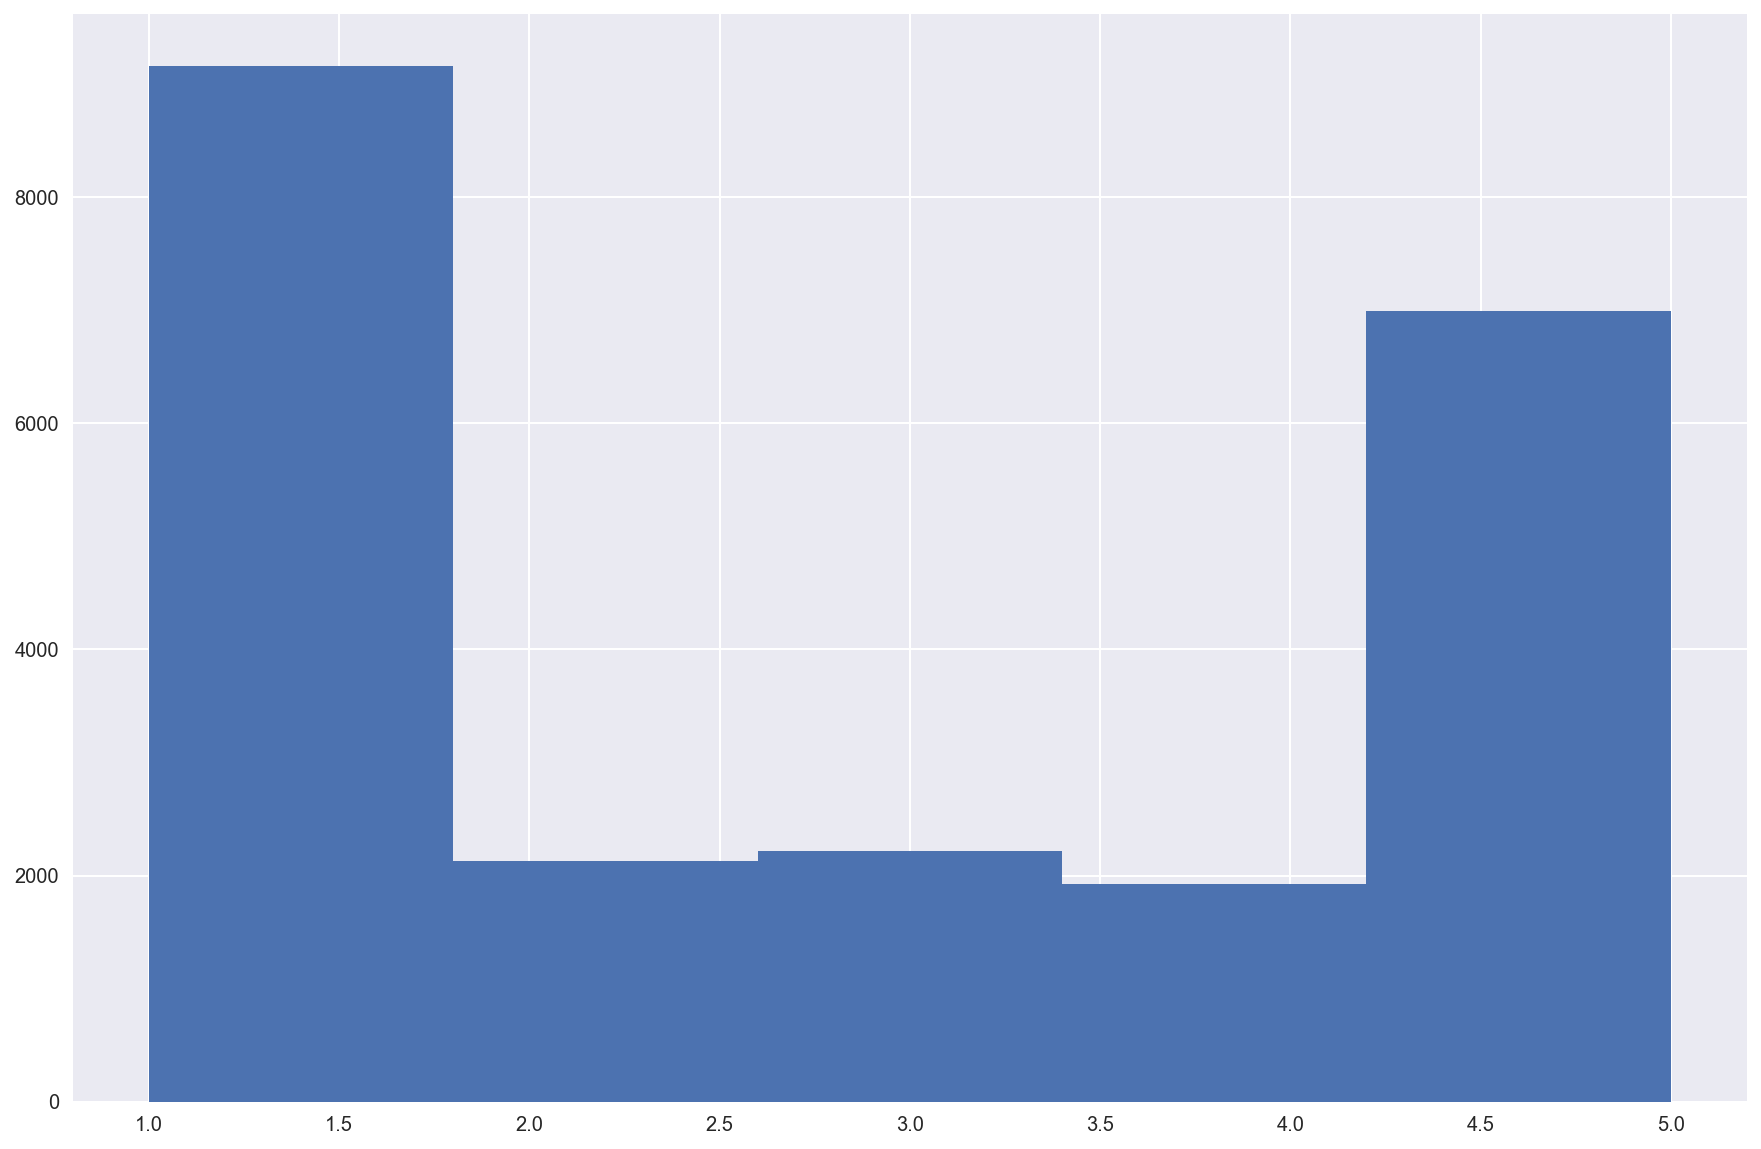

In [184]:
plt.hist(df_nhsrev_new['score'], bins = 5)
plt.show()

In [185]:
#DATA PREPROCESSING
# Lower casing

# Change the reviews type to string
df_nhsrev['content'] = df_nhsrev['content'].astype(str)# Before lowercasing
# Before lowercasing
print(df_nhsrev['content'][2])

Didn't work. Pointless. Billions of pounds wasted. Delete this app off the store.


In [186]:
#Lowercase all reviews
df_nhsrev['content']= df_nhsrev['content'].apply(lambda x: x.lower())
print(df_nhsrev['content'][2]) ## to see the difference

didn't work. pointless. billions of pounds wasted. delete this app off the store.


In [187]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hafidz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [188]:
#edited from https://www.tensorscience.com/nlp/sentiment-analysis-tutorial-in-python-classifying-reviews-on-movies-and-products
import string

df_nhsrev['wordCount'] = [len(review.split()) for review in df_nhsrev['content']]

df_nhsrev['uppercaseCharCount'] = [sum(char.isupper() for char in review) \
                              for review in df_nhsrev['content']]                           

df_nhsrev['specialCharCount'] = [sum(char in string.punctuation for char in review) \
                            for review in df_nhsrev['content']]               

In [196]:
df_nhsrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

,content,score,sentiment_polarity,sentiment_subjective,wordCount,uppercaseCharCount,specialCharCount
0,no help at all with my enquiry,1,0.000000,0.000000,7,0,0
1,the app is good but trying to get an update for a travel pass for my wife is proving difficult. her 2d runs out on 13th may we go on holiday 18th may i have spent many hours today trying to update...,4,0.210714,0.510714,73,0,1
2,didn't work. pointless. billions of pounds wasted. delete this app off the store.,1,-0.225000,0.250000,13,0,5
3,lols,1,0.000000,0.000000,1,0,0
4,great,5,0.800000,0.750000,1,0,0
...,...,...,...,...,...,...,...
22429,tells me is installed but not on phone. can't get as far as putting the code i have been given in. doesn't inspire confidence. it eventually downloaded and the code works. this needs to be slicker...,3,0.100000,1.000000,55,0,10
22430,"the emails from the nhs could do a better job of highlighting the access codes, since they do waffle on quite a bit and we're all busy. assuming you did read your email carefully and collected the...",4,0.346667,0.591667,51,0,7
22431,seems to work really well. super simple setup. people stop giving it 1* because you don't have a signup code. that is not what the rating system is for.,5,0.177778,0.407937,29,0,6
22432,"not able to install ,code didn't work",1,-0.250000,0.625000,7,0,2


In [189]:
#Removing stopwords
#Using nltk
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from string import punctuation

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [190]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

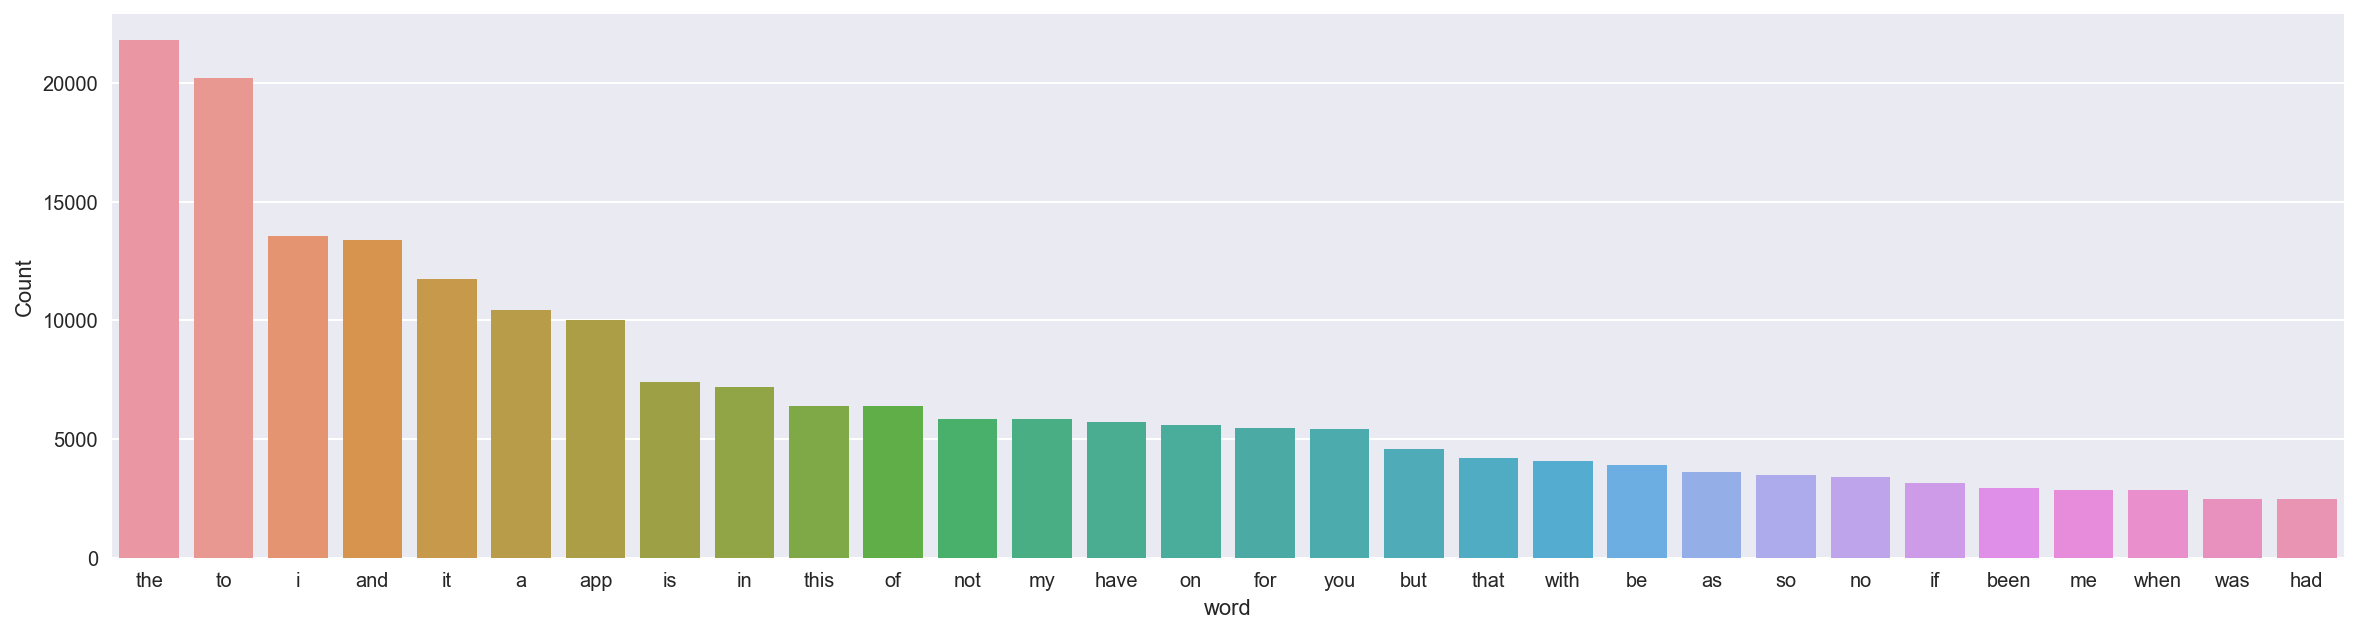

In [204]:
freq_words(df_nhsrev['content'])

In [205]:
#check if there is any special character
alphabet = string.ascii_letters+string.punctuation
print(df_nhsrev.content.str.strip(alphabet).astype(bool).any())

extracted_emojis=[]

def extract_emojis(s):
    expe = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    #return expe.findall(s)
    return expe.sub(r'',s)

for y in df_nhsrev['content']:
    #print(str(extract_emojis(y)))
    extracted_emojis.append(str(extract_emojis(y)))
    
print(extracted_emojis)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [218]:
df_nhsrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

,content,score,sentiment_polarity,sentiment_subjective,wordCount,uppercaseCharCount,specialCharCount
0,no help at all with my enquiry,1,0.000000,0.000000,7,0,0
1,the app is good but trying to get an update for a travel pass for my wife is proving difficult. her 2d runs out on 13th may we go on holiday 18th may i have spent many hours today trying to update...,4,0.210714,0.510714,73,0,1
2,didn't work. pointless. billions of pounds wasted. delete this app off the store.,1,-0.225000,0.250000,13,0,5
3,lols,1,0.000000,0.000000,1,0,0
4,great,5,0.800000,0.750000,1,0,0
...,...,...,...,...,...,...,...
22429,tells me is installed but not on phone. can't get as far as putting the code i have been given in. doesn't inspire confidence. it eventually downloaded and the code works. this needs to be slicker...,3,0.100000,1.000000,55,0,10
22430,"the emails from the nhs could do a better job of highlighting the access codes, since they do waffle on quite a bit and we're all busy. assuming you did read your email carefully and collected the...",4,0.346667,0.591667,51,0,7
22431,seems to work really well. super simple setup. people stop giving it 1* because you don't have a signup code. that is not what the rating system is for.,5,0.177778,0.407937,29,0,6
22432,"not able to install ,code didn't work",1,-0.250000,0.625000,7,0,2


In [217]:
#Add a column name polarity_rating from changing the score of the review into 3 labels: Pos, Negative Neutral
df_nhsrev['sentiment_rating'] = df_nhsrev['score'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

In [221]:
df_nhsrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","sentiment_rating"]]

,content,score,sentiment_polarity,sentiment_subjective,sentiment_rating
0,no help at all with my enquiry,1,0.000000,0.000000,Negative
1,the app is good but trying to get an update for a travel pass for my wife is proving difficult. her 2d runs out on 13th may we go on holiday 18th may i have spent many hours today trying to update...,4,0.210714,0.510714,Positive
2,didn't work. pointless. billions of pounds wasted. delete this app off the store.,1,-0.225000,0.250000,Negative
3,lols,1,0.000000,0.000000,Negative
4,great,5,0.800000,0.750000,Positive
...,...,...,...,...,...
22429,tells me is installed but not on phone. can't get as far as putting the code i have been given in. doesn't inspire confidence. it eventually downloaded and the code works. this needs to be slicker...,3,0.100000,1.000000,Neutral
22430,"the emails from the nhs could do a better job of highlighting the access codes, since they do waffle on quite a bit and we're all busy. assuming you did read your email carefully and collected the...",4,0.346667,0.591667,Positive
22431,seems to work really well. super simple setup. people stop giving it 1* because you don't have a signup code. that is not what the rating system is for.,5,0.177778,0.407937,Positive
22432,"not able to install ,code didn't work",1,-0.250000,0.625000,Negative


C:\Users\Hafidz\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


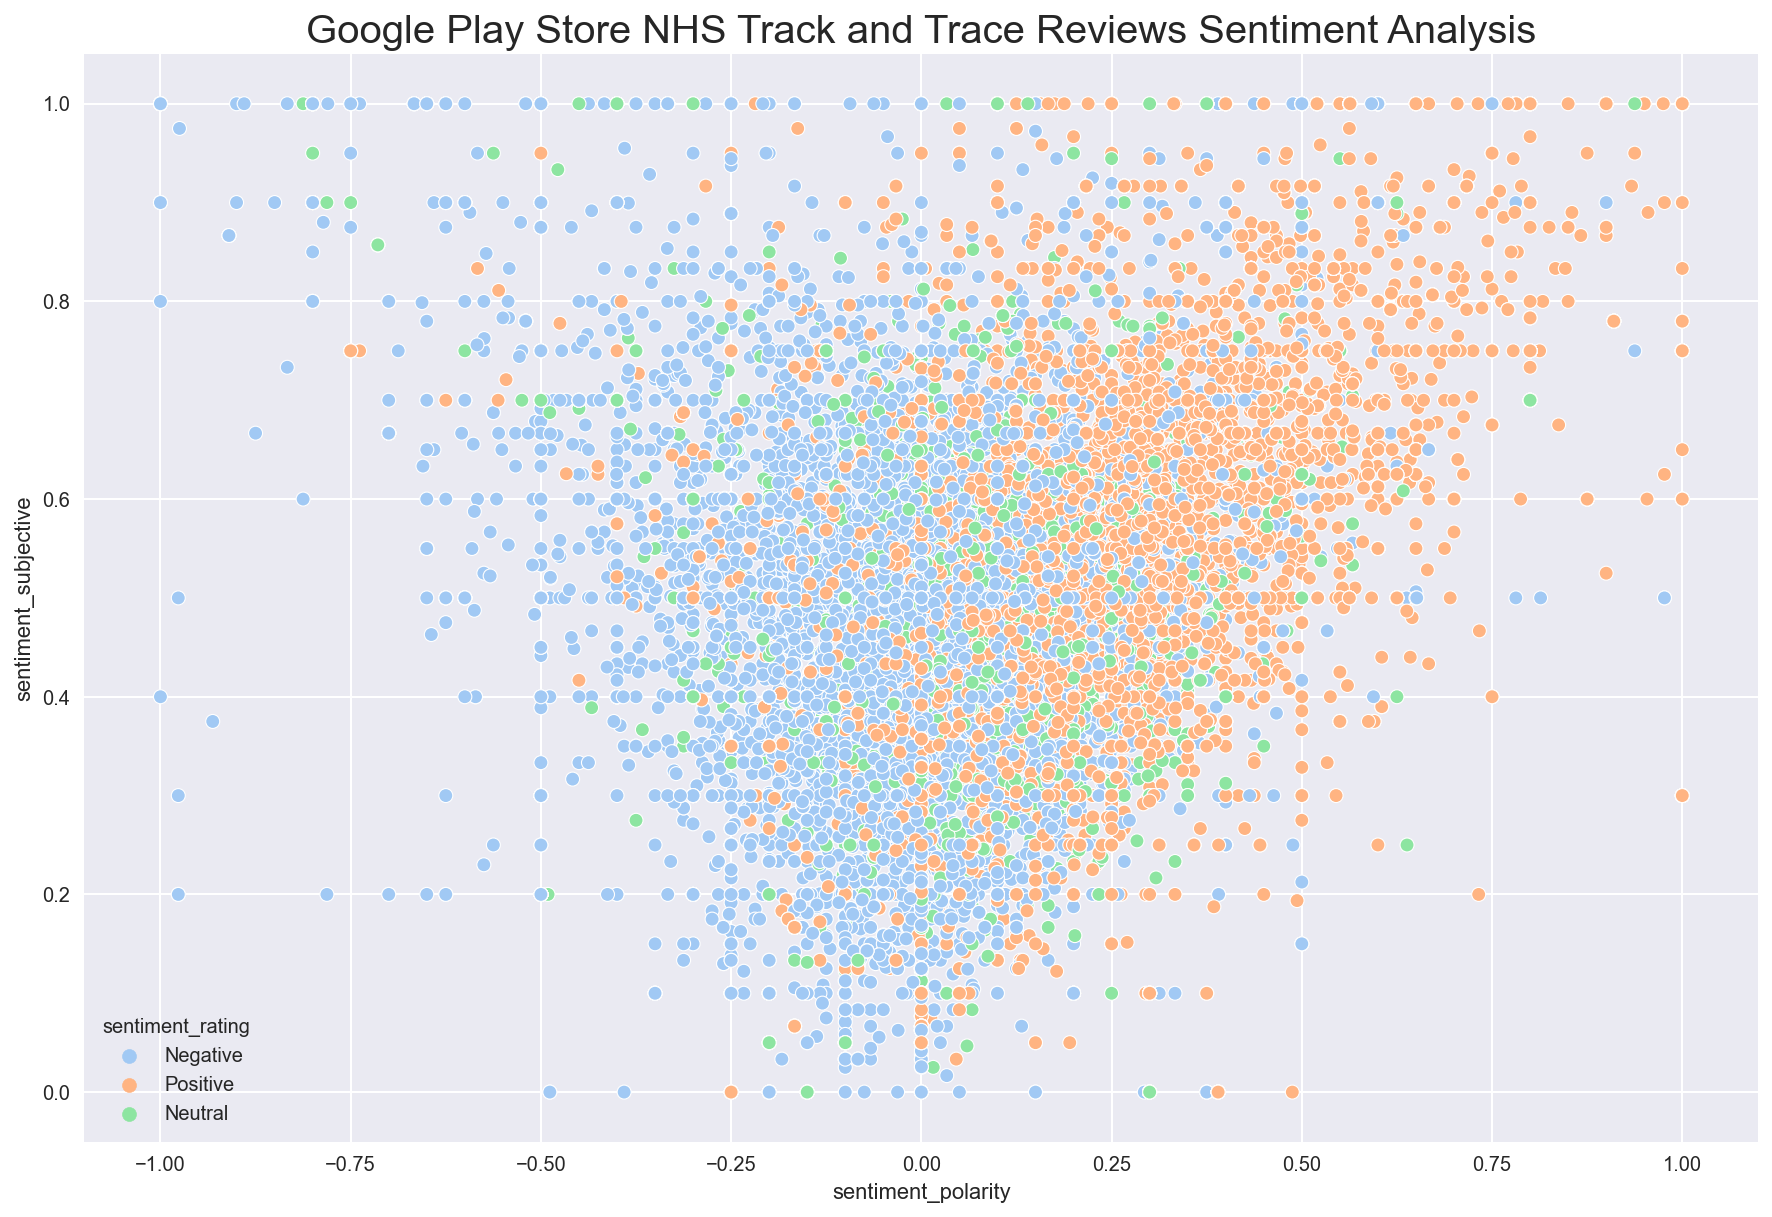

In [223]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 10))
sns.scatterplot(df_nhsrev['sentiment_polarity'], df_nhsrev['sentiment_subjective'], 
                hue = df_nhsrev['sentiment_rating'], edgecolor='white', palette="pastel")
plt.title("Google Play Store NHS Track and Trace Reviews Sentiment Analysis", fontsize=20)
plt.show()

In [219]:
#Print the extracted emojis review column (content) before stopwords
df_nhsrev.to_csv(r'C:\Users\Hafidz\PhDwork\APPREV\df_nhsrev_before_stopwords_sentiment_rating.csv', index = False)

In [210]:
print(df_nhsrev['extracted_emojis'][1])

the app is good but trying to get an update for a travel pass for my wife is proving difficult. her 2d runs out on 13th may we go on holiday 18th may i have spent many hours today trying to update my pass runs out 5thjune please can you advise me how to correct her pass originally i was able to print it alongside mine but this is no longer the case


In [200]:
#Apply stopwords

stop_words=stopwords.words('english')
df_nhsrev['extracted_emojis'] = extracted_emojis
df_nhsrev['extracted_emojis']= df_nhsrev['extracted_emojis'].apply(lambda x:x if x not in stop_words else None)

print(df_nhsrev['extracted_emojis'][1])

the app is good but trying to get an update for a travel pass for my wife is proving difficult. her 2d runs out on 13th may we go on holiday 18th may i have spent many hours today trying to update my pass runs out 5thjune please can you advise me how to correct her pass originally i was able to print it alongside mine but this is no longer the case


In [201]:
#Count after stopwords
#edited from https://www.tensorscience.com/nlp/sentiment-analysis-tutorial-in-python-classifying-reviews-on-movies-and-products
import string

df_nhsrev['wordCount'] = [len(review.split()) for review in df_nhsrev['content']]

df_nhsrev['uppercaseCharCount'] = [sum(char.isupper() for char in review) \
                              for review in df_nhsrev['content']]                           

df_nhsrev['specialCharCount'] = [sum(char in string.punctuation for char in review) \
                            for review in df_nhsrev['content']]               

In [202]:
df_nhsrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

,content,score,sentiment_polarity,sentiment_subjective,wordCount,uppercaseCharCount,specialCharCount
0,no help at all with my enquiry,1,0.000000,0.000000,7,0,0
1,the app is good but trying to get an update for a travel pass for my wife is proving difficult. her 2d runs out on 13th may we go on holiday 18th may i have spent many hours today trying to update...,4,0.210714,0.510714,73,0,1
2,didn't work. pointless. billions of pounds wasted. delete this app off the store.,1,-0.225000,0.250000,13,0,5
3,lols,1,0.000000,0.000000,1,0,0
4,great,5,0.800000,0.750000,1,0,0
...,...,...,...,...,...,...,...
22429,tells me is installed but not on phone. can't get as far as putting the code i have been given in. doesn't inspire confidence. it eventually downloaded and the code works. this needs to be slicker...,3,0.100000,1.000000,55,0,10
22430,"the emails from the nhs could do a better job of highlighting the access codes, since they do waffle on quite a bit and we're all busy. assuming you did read your email carefully and collected the...",4,0.346667,0.591667,51,0,7
22431,seems to work really well. super simple setup. people stop giving it 1* because you don't have a signup code. that is not what the rating system is for.,5,0.177778,0.407937,29,0,6
22432,"not able to install ,code didn't work",1,-0.250000,0.625000,7,0,2


In [93]:
x=(df_nhsrev.groupby('reviewCreatedVersion')['score'].mean())
print(x)

reviewCreatedVersion
3.0.0 (35)      2.815385
3.1.0 (41)      1.455717
3.10 (100)      2.517308
3.12 (111)      2.456140
3.12.2 (114)    2.680851
3.6 (68)        3.857408
3.6 (69)        3.492167
3.6.1 (70)      3.362562
3.6.2 (73)      2.997744
3.7 (81)        2.881188
3.7.1 (83)      2.919847
3.7.2 (85)      2.541183
3.9 (96)        2.565574
4.0 (117)       2.870968
4.0.1 (118)     2.598039
4.1 (123)       2.520000
4.1.1 (124)     2.364921
4.10 (189)      3.344086
4.12 (201)      2.984772
4.13 (208)      3.130435
4.13.1 (213)    2.634921
4.14 (218)      2.322884
4.14.1 (225)    2.041667
4.16 (230)      2.706897
4.17 (240)      2.418367
4.18 (244)      2.593750
4.19 (246)      3.095745
4.19.1 (253)    2.868421
4.2 (131)       2.526316
4.22 (258)      2.884615
4.22.1 (262)    3.375000
4.22.2 (265)    2.363636
4.22.3 (266)    2.357143
4.22.4 (269)    2.511628
4.25 (272)      2.636364
4.26 (276)      3.833333
4.26.1 (280)    3.454545
4.26.2 (286)    2.840909
4.27 (297)      3.500000
4.3 

In [50]:
df_nhsrev.loc[:,["content","score"]]

,content,score
0,could someone please help me with this issue as i am having problems with the app it won't let download or install it,1
1,"track and trace only ever gave me one false positive. apparently, i was never near anyone else who had covid 19. i doubt that. why couldn't i log my lateral flow tests via this app? constantly not...",3
2,"i had positive test. after isolation i unnistalled the app. then i wanted the recovery certificate, tried to put it again on the app and says the test has expired. nonsense",2
3,"this app was never much good. turned up months late, underpowered and seemingly not very reliable. despite living in central london and working with several hospitals the only time it actually pin...",2
4,"what a useless app... i downloaded it after catching covid 2 weeks ago, upon being given a code from the gov/nhs covid website. it gave me 6 days on the clock however 10 days after 1st using it, i...",1
...,...,...
22421,tells me is installed but not on phone. can't get as far as putting the code i have been given in. doesn't inspire confidence. it eventually downloaded and the code works. this needs to be slicker...,3
22422,"the emails from the nhs could do a better job of highlighting the access codes, since they do waffle on quite a bit and we're all busy. assuming you did read your email carefully and collected the...",4
22423,seems to work really well. super simple setup. people stop giving it 1* because you don't have a signup code. that is not what the rating system is for.,5
22424,"not able to install ,code didn't work",1


In [3]:
#Removing stopwords
#Using nltk
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
# stop words
stop_words=stopwords.words('english')
df_nhsrev['content']= df_nhsrev['content'].apply(lambda x:x if x not in stop_words else None)

print(df_nhsrev['content'][2])

ModuleNotFoundError: No module named 'nltk'

In [43]:
#Stemming 
#Stemming function chops off the end of the word 
#and transform the word into its root form. 
#All suffixes like -s, -es, -ed, -ing are removed.

def stemming(x):
    st = PorterStemmer()
    if x is not None:
       for word in x.split():
           st.stem(word)

df_nhsrev['content'].apply(lambda x:stemming(x))
print(df_nhsrev['content'][2])

i had positive test. after isolation i unnistalled the app. then i wanted the recovery certificate, tried to put it again on the app and says the test has expired. nonsense


In [47]:
#Removing stopwords
stop_words=stopwords.words('english')
df_nhsrev['content']=extracted_emojis
df_nhsrev['content']= df_nhsrev['content'].apply(lambda x:x if x not in stop_words else None)

print(df_nhsrev['content'][22424])

not able to install ,code didn't work


In [49]:
df_nhsrev.loc[:,["content","score"]]

,content,score
0,could someone please help me with this issue as i am having problems with the app it won't let download or install it,1
1,"track and trace only ever gave me one false positive. apparently, i was never near anyone else who had covid 19. i doubt that. why couldn't i log my lateral flow tests via this app? constantly not...",3
2,"i had positive test. after isolation i unnistalled the app. then i wanted the recovery certificate, tried to put it again on the app and says the test has expired. nonsense",2
3,"this app was never much good. turned up months late, underpowered and seemingly not very reliable. despite living in central london and working with several hospitals the only time it actually pin...",2
4,"what a useless app... i downloaded it after catching covid 2 weeks ago, upon being given a code from the gov/nhs covid website. it gave me 6 days on the clock however 10 days after 1st using it, i...",1
...,...,...
22421,tells me is installed but not on phone. can't get as far as putting the code i have been given in. doesn't inspire confidence. it eventually downloaded and the code works. this needs to be slicker...,3
22422,"the emails from the nhs could do a better job of highlighting the access codes, since they do waffle on quite a bit and we're all busy. assuming you did read your email carefully and collected the...",4
22423,seems to work really well. super simple setup. people stop giving it 1* because you don't have a signup code. that is not what the rating system is for.,5
22424,"not able to install ,code didn't work",1


In [368]:
#Creating polarity on the column: content (review from the apps)
from textblob import TextBlob
df_nhsrev['polarity'] = df_nhsrev['content'].apply(lambda x: TextBlob(x).polarity)
df_nhsrev['subjective'] = df_nhsrev['content'].apply(lambda x: TextBlob(x).subjectivity)
df_nhsrev.loc[:,["content","polarity","subjective","score"]]

,content,polarity,subjective,score
0,won let install this app can someone please help with this question,0.000000,0.000000,1
1,had positive test after isolation unnistalled the app then wanted the recovery certificate tried put again the app and says the test has expired nonsense,0.227273,0.545455,2
2,this app was never much good turned months late underpowered and seemingly not very reliable despite living central london and working with several hospitals the only time actually pinged was afte...,-0.081981,0.412175,2
3,what useless app downloaded after catching covid weeks ago upon being given code from the gov nhs covid website gave days the clock however days after using still positive with covid symptoms this...,0.046753,0.449351,1
4,irrelevant,-0.500000,1.000000,1
...,...,...,...,...
22420,tells installed but not phone can get far putting the code have been given doesn inspire confidence eventually downloaded and the code works this needs slicker and quicker people are going use peo...,0.100000,1.000000,3
22421,the emails from the nhs could better job highlighting the access codes since they waffle quite bit and all busy assuming you did read your email carefully and collected the one time code the app s...,0.346667,0.591667,4
22422,seems work really well super simple setup people stop giving because you don have signup code that not what the rating system for,0.177778,0.407937,5
22423,not able install code didn work,-0.250000,0.625000,1


In [2]:
from nltk.corpus import stopwords
stoplist = stopwords.words('english') + ['though']

ModuleNotFoundError: No module named 'nltk'

In [325]:
import time
start = time.process_time()

from sklearn.feature_extraction.text import CountVectorizer
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,3))

# matrix of ngrams
ngrams = c_vec.fit_transform(df_nhsrev['content'])

# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)

# list of ngrams
vocab = c_vec.vocabulary_

df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})
print(time.process_time() - start)

74.421875


In [1]:
df_ngram 

NameError: name 'df_ngram' is not defined

In [317]:
# function to remove stopwords in column (content) using nltk
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
df_nhsrev['content'] = df_nhsrev['content'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df_nhsrev['content']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]
df_nhsrev.loc[:,["content","polarity","subjective","score"]]

,content,polarity,subjective,score
0,won let install this app can someone please help with this question,0.000000,0.000000,1
1,had positive test After isolation unnistalled the app Then wanted the recovery certificate tried put again the app and says the test has expired Nonsense,0.227273,0.545455,2
2,This app was never much good Turned months late underpowered and seemingly not very reliable Despite living central London and working with several hospitals the only time actually pinged was afte...,-0.081981,0.412175,2
3,What useless app downloaded after catching covid weeks ago upon being given code from the gov nhs covid website gave days the clock however days after using still positive with covid symptoms This...,0.046753,0.449351,1
4,Irrelevant,-0.500000,1.000000,1
...,...,...,...,...
22420,Tells installed but not phone Can get far putting the code have been given Doesn inspire confidence eventually downloaded and the code works This needs slicker and quicker people are going use peo...,0.100000,1.000000,3
22421,The emails from the NHS could better job highlighting the access codes since they waffle quite bit and all busy Assuming you did read your email carefully and collected the one time code the app s...,0.346667,0.591667,4
22422,Seems work really well Super simple setup People stop giving because you don have signup code That not what the rating system for,0.177778,0.407937,5
22423,Not able install code didn work,-0.250000,0.625000,1


In [312]:
#Using nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
# View a few words from the set
stop_words_list = [w for w in stop_words if w in stopwords.words('english')]
stop_words_list_number = len(stop_words_list)
stop_words_list_number

179

In [313]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [ ]:
#Creating bigram/trigram to search 

In [302]:
#Clean the content text review using stopwords
#from nltk.stem import PorterStemmer
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import nltk
import re
import string

nltk.download('stopwords') 
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Using nltk

stop_words = set(stopwords.words('english'))
# View a few words from the set
stop_words_list = [w for w in stop_words if w in stopwords.words('english')]
stop_words_list_number = len(stop_words_list)
stop_words_list_number

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hafidz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


179

In [303]:
# View a few words from the set
stop_words_list

['couldn',
 'if',
 'on',
 'again',
 'aren',
 'had',
 'having',
 'now',
 "she's",
 'through',
 'are',
 've',
 'didn',
 'hadn',
 'such',
 'is',
 'under',
 'can',
 'some',
 'of',
 'when',
 "shan't",
 'have',
 'further',
 "doesn't",
 'they',
 'should',
 'shan',
 'other',
 'same',
 'herself',
 'too',
 'be',
 "you're",
 'your',
 'why',
 'does',
 'against',
 'after',
 'itself',
 'the',
 "aren't",
 'been',
 'not',
 'o',
 'doesn',
 "hadn't",
 'own',
 'hers',
 'both',
 'to',
 "couldn't",
 'my',
 'their',
 'our',
 "wasn't",
 'yours',
 "shouldn't",
 'while',
 'she',
 'don',
 'her',
 'shouldn',
 'an',
 "hasn't",
 'until',
 'here',
 'am',
 'as',
 'his',
 'which',
 'each',
 'needn',
 'it',
 'into',
 'wasn',
 'him',
 'how',
 'himself',
 'once',
 'above',
 'he',
 'with',
 'what',
 'd',
 'during',
 'at',
 'where',
 'then',
 'mightn',
 "that'll",
 'mustn',
 'this',
 'ma',
 "haven't",
 "should've",
 'yourselves',
 'down',
 "you'll",
 'just',
 'between',
 'weren',
 'theirs',
 'these',
 'we',
 'there',
 'wa

In [279]:
def clean_text(df_nhsrev):
    # convert catacter to lowercase
    df_nhsrev['clean_text']=df_nhsrev['clean_text'].str.lower()
    #remove URLS
    df_nhsrev['clean_text'] = df_nhsrev['clean_text'].apply(lambda elem:re.sub(r"http\S+", "", elem))
    #remove ponctuation
    df_nhsrev['clean_text'] = df_nhsrev['clean_text'].apply(lambda elem:re.sub(r"[^\w\s]", "", elem))
    #remove 
    df_nhsrev['clean_text'] = df_nhsrev['clean_text'].apply(lambda elem:re.sub(r'/n',"",elem))
    #remove degits
    df_nhsrev['clean_text'] = df_nhsrev['clean_text'].apply(lambda elem:re.sub(r'\d+',"",elem))
    #remove multiple spaces
    df_nhsrev['clean_text'] = df_nhsrev['clean_text'].apply(lambda elem:re.sub(r'\s+'," ",elem))
    #remove single caracter
    df_nhsrev['clean_text'] = df_nhsrev['clean_text'].apply(lambda elem:re.sub(r'\s+[a-zA-Z]\s+'," ",elem))
    return df_nhsrev

In [284]:
import spacy
import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [285]:
# remove unwanted characters, numbers and symbols
df_nhsrev['content'] = df_nhsrev['content'].str.replace("[^a-zA-Z#]", " ")

C:\Users\Hafidz\AppData\Local\Temp/ipykernel_24884/2937470822.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_nhsrev['content'] = df_nhsrev['content'].str.replace("[^a-zA-Z#]", " ")


In [232]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

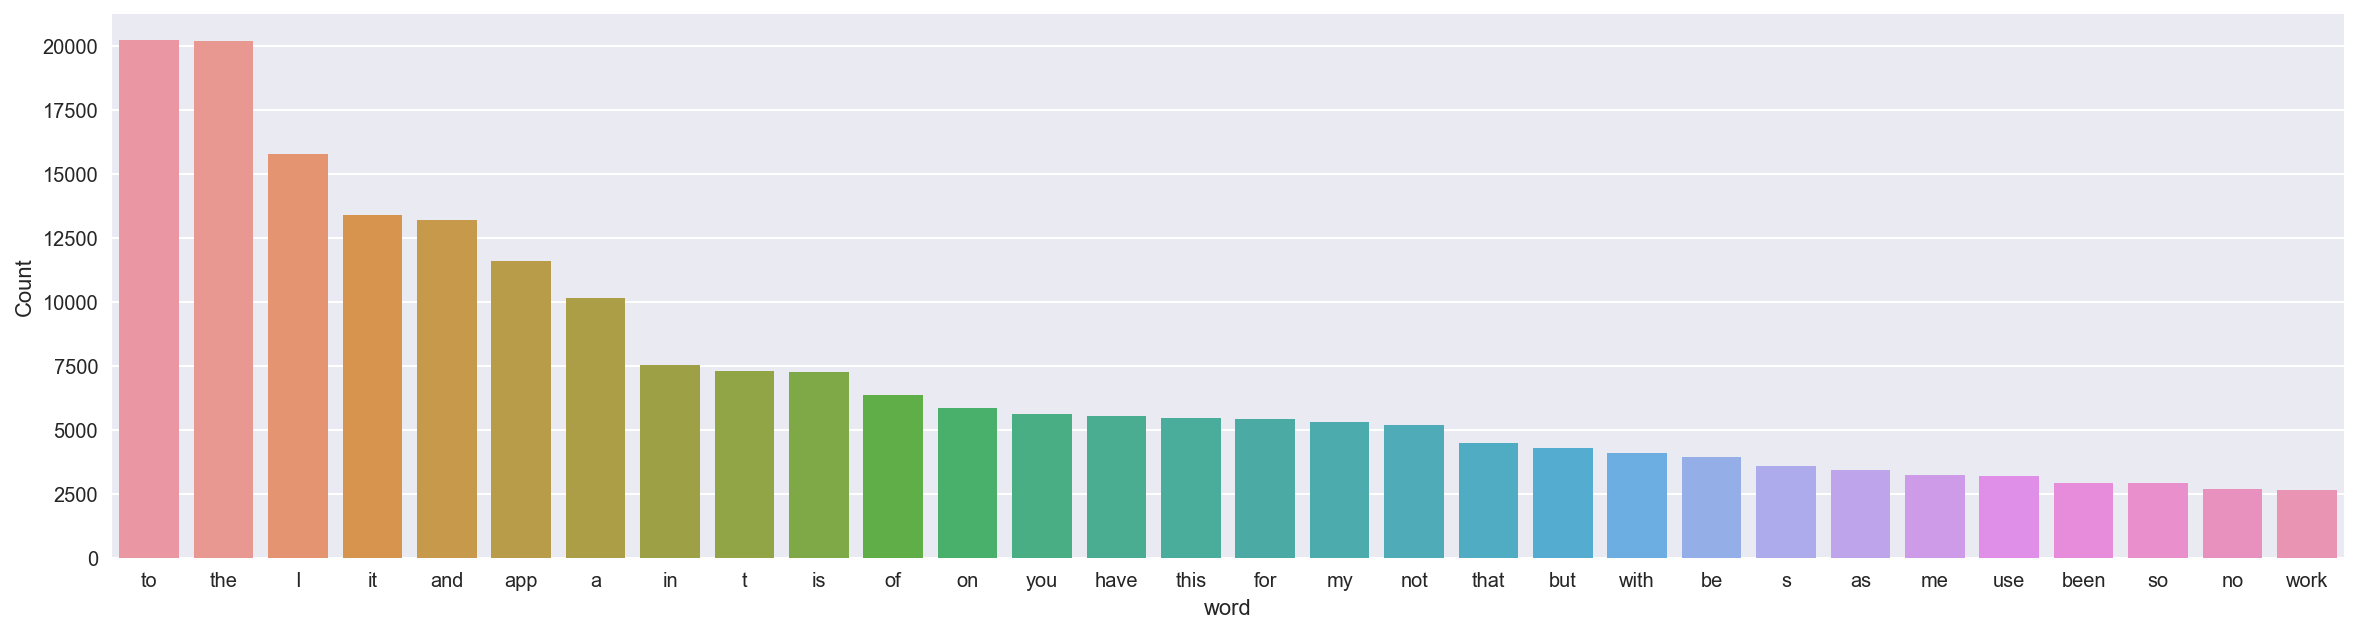

In [233]:
freq_words(df_nhsrev['content'])

In [253]:
#Using nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [254]:
# function to remove stopwords in CONTENT column using nltk
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
df_nhsrev['content'] = df_nhsrev['content'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df_nhsrev['content']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

In [ ]:
#Using spacy
#pip install -U pip setuptools wheel  --installing related package
#pip install -U spacy
#python -m spacy download en_core_web_sm

In [255]:
df_nhsrev2 = df_nhsrev.loc[:,['content', 'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt']]
df_nhsrev2

,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,Good,5,0,4.27 (297),2022-04-21 12:55:13,None,NaT
1,Good dies wgat want,4,0,4.27 (297),2022-04-20 12:26:46,None,NaT
2,Meh,1,0,4.27 (297),2022-04-19 13:24:31,None,NaT
3,Useful info this NHS APP,4,0,4.27 (297),2022-04-19 00:50:38,None,NaT
4,Exe letaln,4,0,4.27 (297),2022-04-18 16:37:36,None,NaT
...,...,...,...,...,...,...,...
22417,Tells installed but not phone Can get far putting the code have been given Doesn inspire confidence eventually downloaded and the code works This needs slicker and quicker people are going use peo...,3,7,3.0.0 (35),2020-08-13 16:25:10,"Hello, the app is located next to other apps you have installed on your smartphone, called “NHS COVID-19”. If you are unable to find the app on your device head to our website for further instruct...",2020-08-13 16:13:18
22418,The emails from the NHS could better job highlighting the access codes since they waffle quite bit and all busy Assuming you did read your email carefully and collected the one time code the app s...,4,19,3.0.0 (35),2020-08-13 16:04:40,"Hello, thank you for your comments, we really appreciate it. To find out more about the NHS Test and Trace app visit: https://covid19.nhs.uk/",2020-08-14 07:37:04
22419,Seems work really well Super simple setup People stop giving because you don have signup code That not what the rating system for,5,9,3.0.0 (35),2020-08-13 16:03:33,"Hello, thank you for your comments, we really appreciate it. To find out more about the NHS Test and Trace app visit: https://covid19.nhs.uk/",2020-08-14 07:37:19
22420,Not able install code didn work,1,0,3.0.0 (35),2020-08-13 15:27:46,"Hello, the unique codes are single-use. If you live on the Isle of Wight, you may be able to use one of the other 3 codes from your letter. Unfortunately we are not able to issue new codes. Find o...",2020-08-13 15:39:11


In [260]:
!python spacy download en # one time run

python: can't open file 'C:\Users\Hafidz\PhDwork\APPREV\spacy': [Errno 2] No such file or directory


In [258]:
spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

SyntaxError: invalid syntax (Temp/ipykernel_24884/2687527068.py, line 1)

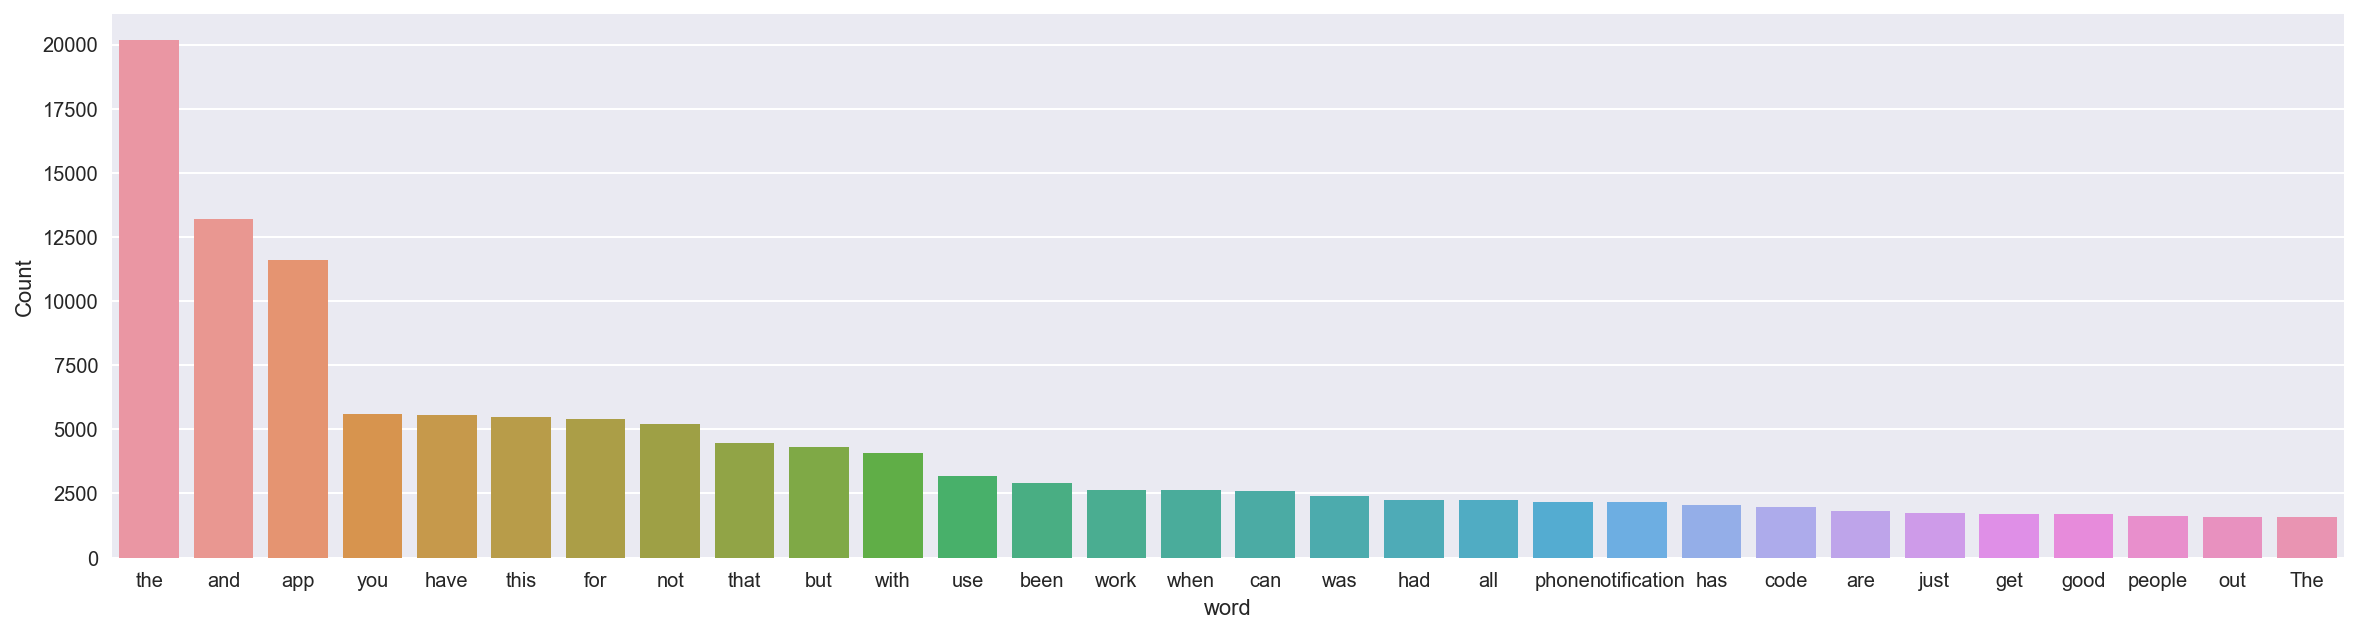

In [256]:
freq_words(df_nhsrev2['content'])

In [49]:
#Using VADERSentiment
#pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
vs = analyzer.polarity_scores('I felt terrible today')
print(vs)

{'neg': 0.508, 'neu': 0.492, 'pos': 0.0, 'compound': -0.4767}


In [52]:
def calc_vader_sentiment(text):
    sentiment = 1    

    vs = analyzer.polarity_scores(str(text))
    compound = vs['compound']    
    
    if(compound == 0):
        sentiment = -1
    elif(compound >= 0.05):
        sentiment = 2
    elif(compound <= -0.05):
        sentiment = 0   
    return sentiment

In [98]:
#Clean the content text review using stopwords
#from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords') 
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string

stop_words = set(stopwords.words('english'))
# View a few words from the set
stop_words_list = [w for w in stop_words if w in stopwords.words('english')]
stop_words_list_number = len(stop_words_list)
#stop_words_list
stop_words_list_number

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hafidz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


179

In [99]:
def clean_text(df_nhsvovid19apps):
    # convert catacter to lowercase
    df_nhsvovid19apps['clean_content']=df_nhsvovid19apps['content'].str.lower()
    #remove URLS
    df_nhsvovid19apps['clean_content'] = df_nhsvovid19apps['content'].apply(lambda elem:re.sub(r"http\S+", "", elem))
    #remove ponctuation
    df_nhsvovid19apps['clean_content'] = df_nhsvovid19apps['content'].apply(lambda elem:re.sub(r"[^\w\s]", "", elem))
    #remove 
    df_nhsvovid19apps['clean_content'] = df_nhsvovid19apps['content'].apply(lambda elem:re.sub(r'/n',"",elem))
    #remove degits
    df_nhsvovid19apps['clean_content'] = df_nhsvovid19apps['content'].apply(lambda elem:re.sub(r'\d+',"",elem))
    #remove multiple spaces
    df_nhsvovid19apps['clean_content'] = df_nhsvovid19apps['content'].apply(lambda elem:re.sub(r'\s+'," ",elem))
    #remove single caracter
    df_nhsvovid19apps['clean_content'] = df_nhsvovid19apps['content'].apply(lambda elem:re.sub(r'\s+[a-zA-Z]\s+'," ",elem))
    return df_nhsvovid19apps

In [100]:
df_nhsvovid19apps=clean_text(df_nhsvovid19apps['clean_ontent'])
df_nhsvovid19apps

KeyError: 'clean_ontent'

In [ ]:
df = pd.DataFrame({
    'uid': list(df_nhsvovid19apps.index.values),
    'text': df_nhsvovid19apps['content'],
    'label': [calc_vader_sentiment(x) for x in df_nhsvovid19apps['content']]
})